Using device: cpu
Loaded complete model from best_unet_model_complete.pth


C:\Users\rihem\AppData\Local\Temp\ipykernel_22104\317414971.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(model_path, map_location=device)


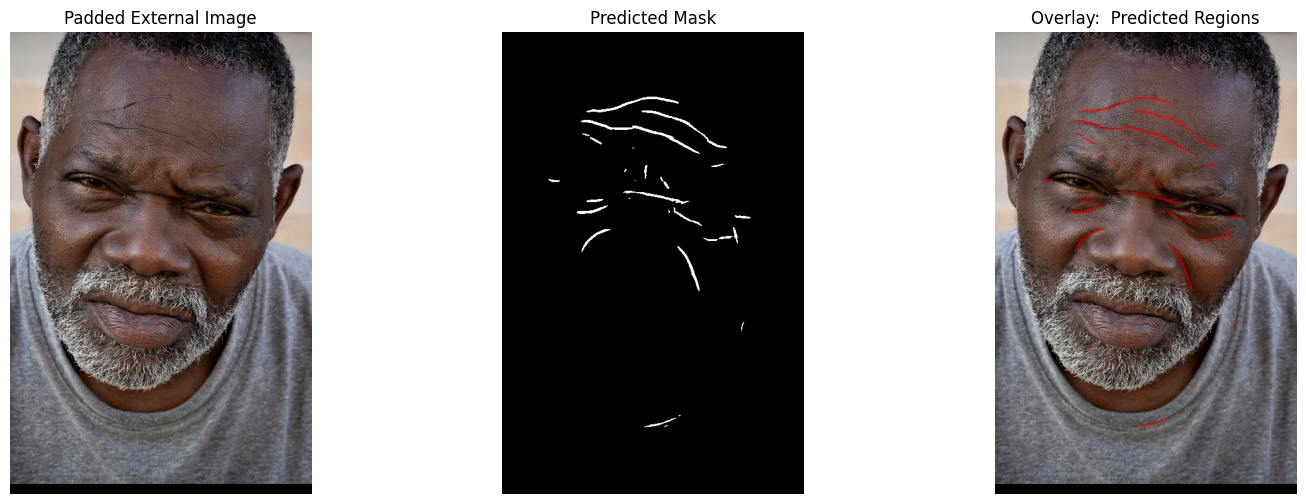

In [3]:
import math
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

def pad_to_divisible(img, div=32):
    """
    Pads the image so that its height and width 
    """
    h, w, _ = img.shape
    new_h = math.ceil(h / div) * div
    new_w = math.ceil(w / div) * div
    pad_bottom = new_h - h
    pad_right = new_w - w
    padded = cv2.copyMakeBorder(img, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model 
model_path = "best_unet_model_complete.pth"
if os.path.exists(model_path):
    loaded_model = torch.load(model_path, map_location=device)
    loaded_model.eval()
    print("Loaded complete model from", model_path)
else:
    raise FileNotFoundError(f"Model file not found at {model_path}")

#  path to image.
external_image_path = "people-7286539_960_720.jpg"  # Update with your image path

# Load image using OpenCV.
external_image = cv2.imread(external_image_path)
if external_image is None:
    raise FileNotFoundError(f"Error: Image not found at {external_image_path}")
else:
    # Convert from BGR to RGB.
    external_image_rgb = cv2.cvtColor(external_image, cv2.COLOR_BGR2RGB)
    # Pad the image so its dimensions 
    external_image_padded = pad_to_divisible(external_image_rgb, div=32)
    
    #  normalize the image 
    external_image_norm = external_image_padded.astype(np.float32) / 255.0
    # Convert to tensor
    external_tensor = torch.from_numpy(external_image_norm).permute(2, 0, 1)
    # Add batch dimension 
    external_tensor = external_tensor.unsqueeze(0).to(device)

    # Perform inference.
    with torch.no_grad():
        output = loaded_model(external_tensor)
      
        pred_mask = (torch.sigmoid(output) > 0.3).float()
    # Convert predicted mask to numpy array 
    pred_mask_np = pred_mask.cpu().squeeze().numpy()
 
    overlay_image = external_image_padded.astype(np.float32)
    
    mask_bool = pred_mask_np > 0.5
 
    red_color = np.array([255, 0, 0], dtype=np.float32)
    alpha = 0.5  

    # 
    overlay_image[mask_bool] = (1 - alpha) * overlay_image[mask_bool] + alpha * red_color
    overlay_image = np.clip(overlay_image, 0, 255).astype(np.uint8)

    # Plot original padded image, predicted mask, and overlay result.
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(external_image_padded)
    axes[0].set_title("Padded External Image")
    axes[0].axis("off")
    
    axes[1].imshow(pred_mask_np, cmap="gray")
    axes[1].set_title("Predicted Mask")
    axes[1].axis("off")
    
    axes[2].imshow(overlay_image)
    axes[2].set_title("Overlay:  Predicted Regions")
    axes[2].axis("off")
    
    plt.show()
